In [3]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [4]:
env = CliffWalkingEnv()

In [5]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [6]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
        

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        state_t_plus_1 = None
        
        state_t = env.reset()
        action_probs = policy(state_t)
        action_t = np.random.choice(np.arange(len(action_probs)), p=action_probs)

        for t in range(10000):
            
            if state_t_plus_1 is not None:
                state_t = state_t_plus_1
                action_t = action_t_plus_1
            # generate action according to probs
            
            state_t_plus_1, reward, done, _ = env.step(action_t)
            action_probs = policy(state_t_plus_1)
            action_t_plus_1 = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            action_t_plus_1_best = np.argmax(action_probs)
            Q[state_t][action_t] = Q[state_t][action_t] + alpha*(reward + discount_factor * Q[state_t_plus_1][action_t_plus_1_best] - Q[state_t][action_t])
            
            stats.episode_rewards[i_episode] += reward
            
            #print(reward)
            #print(Q[state_t][action_t])    
            if done:
                Q[state_t_plus_1][0] = 0
                stats.episode_lengths[i_episode] = t
                break  
        # Implement this!
        
    return Q, stats

In [7]:
Q, stats = q_learning(env, 500)

Episode 500/500.

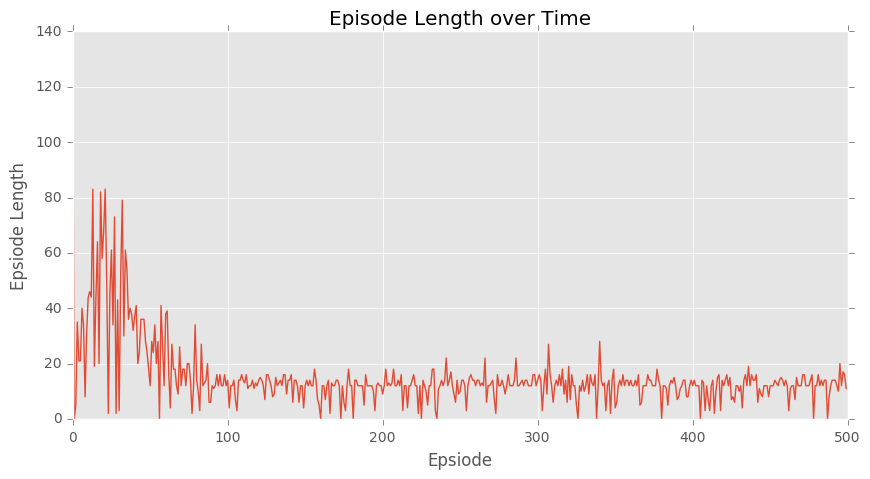

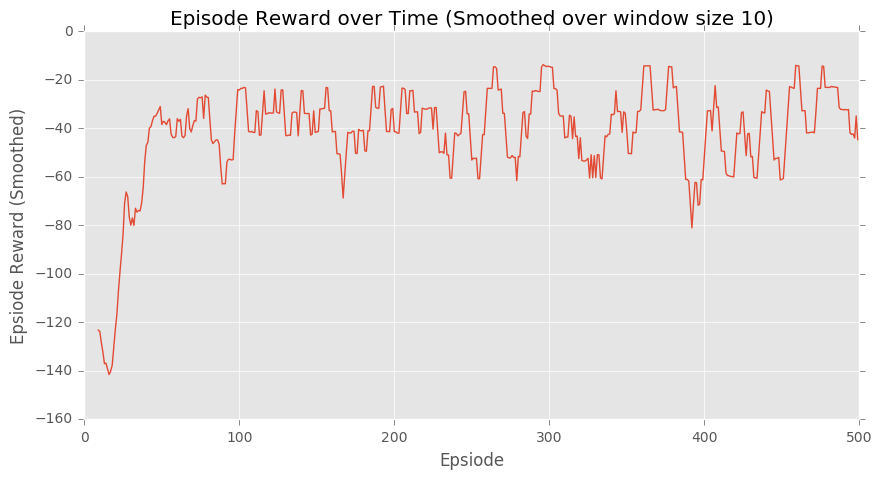

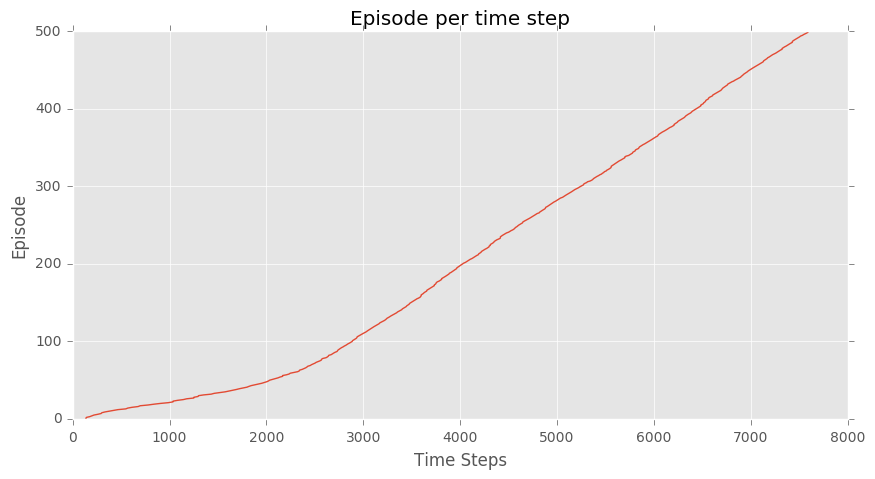

(<matplotlib.figure.Figure at 0x7f0eb6cdd908>,
 <matplotlib.figure.Figure at 0x7f0eb48e7e48>)

In [8]:
plotting.plot_episode_stats(stats)